### FPGA Acelleration for Image Processing: Thresholding

#### Import overlay in instantiate FPGA modules

In [4]:
from pynq import Overlay, Xlnk

import pynq.lib.dma
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt

overlay = Overlay('/home/xilinx/pynq/overlays/sobel/sobel_g.bit')
print(overlay.ip_dict)
dma = overlay.axi_dma_0

/usr/local/lib/python3.6/dist-packages/pynq/overlay.py:299: UserWarning: Users will not get PARAMETERS / REGISTERS information through TCL files. HWH file is recommended.
  warnings.warn(message, UserWarning)


{'axi_dma_0': {'phys_addr': 1077936128, 'addr_range': 65536, 'type': 'xilinx.com:ip:axi_dma:7.1', 'state': None, 'interrupts': {}, 'gpio': {}, 'fullpath': 'axi_dma_0', 'mem_id': 'SEG_axi_dma_0_Reg', 'driver': <class 'pynq.lib.dma.DMA'>}, 'buffer_size_0': {'phys_addr': 1136656384, 'addr_range': 65536, 'type': 'ucdenver.pvt:user:buffer_size:1.0', 'state': None, 'interrupts': {}, 'gpio': {}, 'fullpath': 'buffer_size_0', 'mem_id': 'SEG_buffer_size_0_S00_AXI_reg', 'driver': <class 'pynq.overlay.DefaultIP'>}}


/usr/local/lib/python3.6/dist-packages/pynq/lib/dma.py:200: UserWarning: Failed to find parameter c_sg_length_width; users should really use *.hwh files for overlays.
  warnings.warn(message, UserWarning)


#### Create FPGA "driver"
Pass image path to FGPA_sobel and it will configure the filter and start the transaction

In [10]:
dma = overlay.axi_dma_0
#img_len must be configured to the width of the image
img_len = overlay.buffer_size_0

In [11]:
def FPGA_sobel(img_path):
    xlnk = Xlnk()
    img = cv2.imread(img_path,0) #read image
    height,width = img.shape
    x = img.flatten()
    img_len.write(0,width) #configure image length
    in_buffer = xlnk.cma_array(shape=(x.shape[0]), dtype = np.int32)
    out_buffer = xlnk.cma_array(shape=((width)*(height-2)), dtype = np.int32)

    np.copyto(in_buffer,x)
    start_time = time.time() #start transaction
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)
    dma.sendchannel.wait()
    dma.recvchannel.wait()
    stop_time = time.time()
    print('FPGA processing time: {}'.format(stop_time-start_time))
    return out_buffer.reshape((height-2), (width)), (stop_time-start_time)

### Process image in FPGA

In [13]:
image_path = 'images/maze.bmp'
out,_ = FPGA_sobel(image_path)

FPGA processing time: 0.004322052001953125


#### Process images with FPGA sobel:
1.) Maze

2.) Lena

3.) Valve

Text(0.5,1,'Sobel')

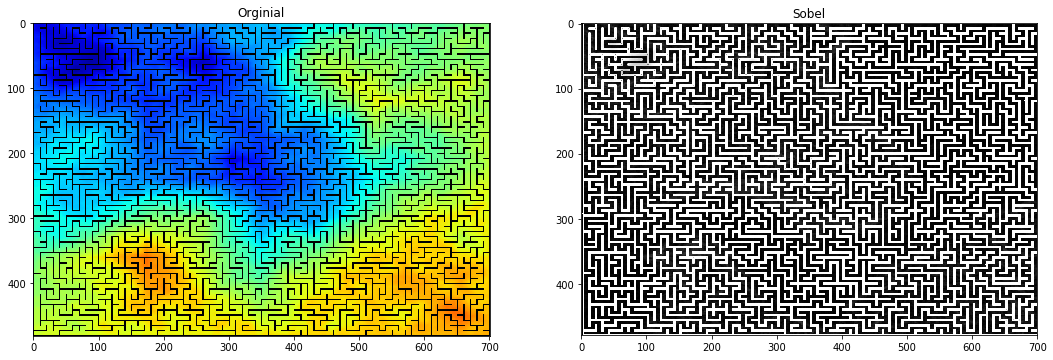

In [14]:
fig = plt.figure()
fig = plt.figure(figsize=(fig.get_size_inches()*3))
fig.add_subplot(1,2,1)
plt.imshow(cv2.imread(image_path), cmap=plt.get_cmap('gray'))
plt.title('Orginial')
fig.add_subplot(1,2,2)
plt.imshow(out, cmap=plt.get_cmap('gray'))
plt.title('Sobel')

FPGA processing time: 0.003563404083251953


Text(0.5,1,'Sobel')

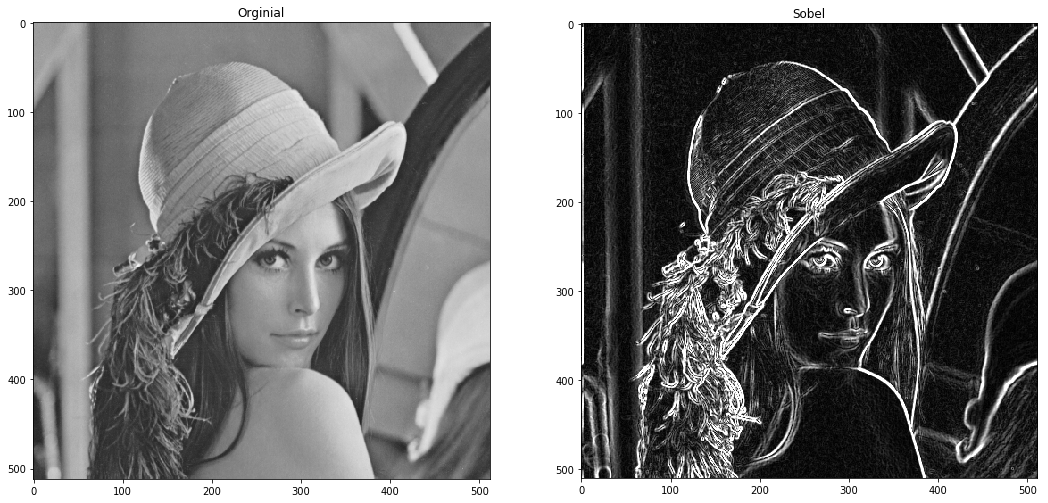

In [15]:
image_path = 'images/lena_gray.bmp'
out,_ = FPGA_sobel(image_path)

fig = plt.figure()
fig = plt.figure(figsize=(fig.get_size_inches()*3))
fig.add_subplot(1,2,1)
plt.imshow(cv2.imread(image_path), cmap=plt.get_cmap('gray'))
plt.title('Orginial')
fig.add_subplot(1,2,2)
plt.imshow(out, cmap=plt.get_cmap('gray'))
plt.title('Sobel')

FPGA processing time: 0.0039064884185791016


Text(0.5,1,'Sobel')

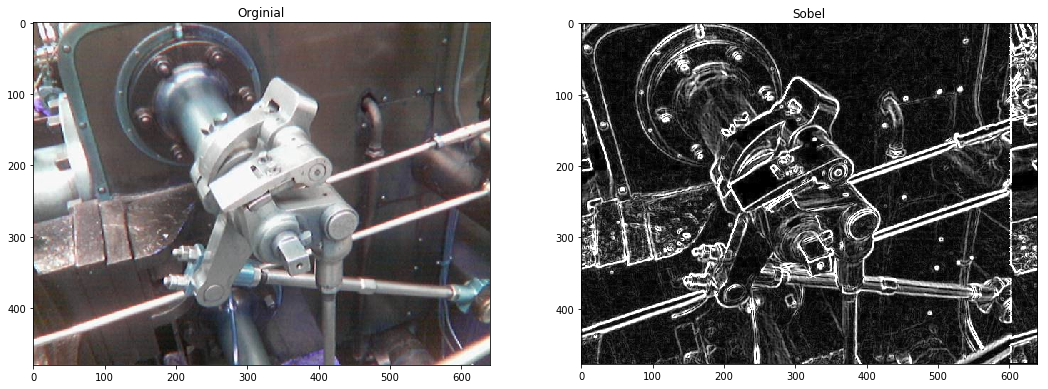

In [16]:
image_path = 'images/valve.png'
out,_ = FPGA_sobel(image_path)

fig = plt.figure()
fig = plt.figure(figsize=(fig.get_size_inches()*3))
fig.add_subplot(1,2,1)
plt.imshow(cv2.imread(image_path), cmap=plt.get_cmap('gray'))
plt.title('Orginial')
fig.add_subplot(1,2,2)
plt.imshow(out, cmap=plt.get_cmap('gray'))
plt.title('Sobel')

In [ ]:
### FPGA acceleration

In [48]:
image_path = 'images/maze.bmp'
img = cv2.imread(image_path,0)

s_start = time.time()
sobel_x = cv2.Sobel(img, cv2.CV_8U, 1, 0, ksize=3)
sobel_y = cv2.Sobel(img, cv2.CV_8U, 0, 1, ksize=3)
sobel_soft = cv2.addWeighted(sobel_x, 0.5, sobel_y, 0.5, 0)
s_delay = time.time()-s_start

_,f_delay = FPGA_sobel(image_path)
print("Software processing time : {}".format(s_delay))
print("Acceleration : {}".format(s_delay/f_delay))

FPGA processing time: 0.00431513786315918
Software processing time : 0.06280159950256348
Acceleration : 14.553787502071938
